In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import os

# Import our modules
from model import VAE_WGAN
from dataset import get_data_loaders

In [41]:
# ================= CONFIGURATION =================
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "vae_wgan_final.pth"  # Ensure this matches your saved model name
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [42]:
def plot_results(fpr, tpr, roc_auc, labels, scores, threshold, cm):
    """Generates graphs for ROC, Score Distribution, and Confusion Matrix"""
    plt.figure(figsize=(15, 5))

    # Plot 1: ROC Curve
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    # Plot 2: Score Distribution
    plt.subplot(1, 3, 2)
    sns.histplot(scores[labels==0], color='green', label='Normal', kde=True, stat="density", alpha=0.5)
    sns.histplot(scores[labels==1], color='red', label='Fire', kde=True, stat="density", alpha=0.5)
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.title('Anomaly Score Distribution')
    plt.legend()

    # Plot 3: Confusion Matrix
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fire'], yticklabels=['Normal', 'Fire'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'evaluation_metrics.png'))
    print(f"Saved metrics plot to {RESULTS_DIR}/evaluation_metrics.png")

In [43]:
def visualize_reconstructions(data):
    """
    Visualizes Input vs Reconstruction vs Error Map
    """
    imgs, recons, errors, labels = data

    # Select 5 random indices to show
    # Try to pick some Normal (0) and some Fire (1)
    indices = np.random.choice(len(imgs), 5, replace=False)

    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(indices):
        # Original
        plt.subplot(5, 3, 3*i + 1)
        show_img(imgs[idx], f"Input (Label: {int(labels[idx])})")

        # Reconstruction
        plt.subplot(5, 3, 3*i + 2)
        show_img(recons[idx], "Reconstruction")

        # Error Map (Heatmap)
        plt.subplot(5, 3, 3*i + 3)
        # Average error across channels for visualization
        err = errors[idx].mean(dim=0).numpy()
        plt.imshow(err, cmap='hot')
        plt.colorbar()
        plt.title(f"Error Map (MSE: {err.mean():.4f})")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'visual_examples.png'))
    print(f"Saved visual examples to {RESULTS_DIR}/visual_examples.png")

In [44]:
def show_img(tensor, title):
    # Un-normalize from [-1, 1] to [0, 1]
    img = tensor.permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

### ***evaluate***

In [45]:
print(f"Evaluating on {DEVICE}...")

Evaluating on cuda...


In [46]:
# 1. Load Data
# We only need the Test Loader here
_, test_loader = get_data_loaders('modis_dataset_brazil', batch_size=BATCH_SIZE)

Total Normal: 9298
Total Fire: 9299
--- Split Summary ---
Train Set (Normal Only): 7438 images
Test Set (Normal):       1860 images
Test Set (Fire):         1860 images
Total Test Set:          3720 images


In [47]:
# 2. Load Model
model = VAE_WGAN().to(DEVICE)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print("Model loaded successfully.")
else:
    print(f"ERROR: Model file {MODEL_PATH} not found!")

Model loaded successfully.


In [48]:
model.eval()

VAE_WGAN(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2)
      (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2)
    )
    (fc_mu): Linear(in_features=4096, out_features=128, bias=True)
    (fc_logvar): Linear(in_features=4096, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_featu

In [49]:
# Store results
all_scores = []
all_labels = []

In [50]:
# To save some examples for visualization
saved_examples = []

In [51]:
print("Calculating Anomaly Scores...")
with torch.no_grad():
    for imgs, labels in tqdm(test_loader):
        imgs = imgs.to(DEVICE)

        # Forward pass
        recon_imgs, _, _ = model(imgs)

        # Calculate Error per image (Anomaly Score)
        # We use Mean Squared Error averaged over pixels
        # Shape: [Batch_Size, Channels, H, W] -> [Batch_Size]
        error_map = (imgs - recon_imgs) ** 2
        mse_score = error_map.view(error_map.size(0), -1).mean(dim=1)

        all_scores.extend(mse_score.cpu().numpy())
        all_labels.extend(labels.numpy())

        # Save first batch for visualization later
        if len(saved_examples) == 0:
            saved_examples = (imgs.cpu(), recon_imgs.cpu(), error_map.cpu(), labels.cpu())

Calculating Anomaly Scores...


100%|██████████| 117/117 [00:19<00:00,  6.13it/s]


In [52]:
all_scores = np.array(all_scores)
all_labels = np.array(all_labels)

In [53]:
# 3. Calculate Metrics (ROC / AUC)
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

In [54]:
print(f"\n================ RESULTS ================")
print(f"AUC Score: {roc_auc:.4f} (1.0 is perfect, 0.5 is random guessing)")


================ RESULTS ================
AUC Score: 0.7330 (1.0 is perfect, 0.5 is random guessing)


In [55]:
# 4. Find Optimal Threshold (Youden's J statistic)
# Maximize (TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Anomaly Threshold: {optimal_threshold:.6f}")

Optimal Anomaly Threshold: 0.007855


In [56]:
# 5. Confusion Matrix at Optimal Threshold
predictions = (all_scores > optimal_threshold).astype(int)
cm = confusion_matrix(all_labels, predictions)

In [57]:
# Calculate Accuracy, Precision, Recall
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

In [58]:
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f} (How many detected fires were real?)")
print(f"Recall:    {recall:.4f} (How many real fires did we find?)")

Accuracy:  0.6718
Precision: 0.7217 (How many detected fires were real?)
Recall:    0.5591 (How many real fires did we find?)


Saved metrics plot to results/evaluation_metrics.png
Saved visual examples to results/visual_examples.png


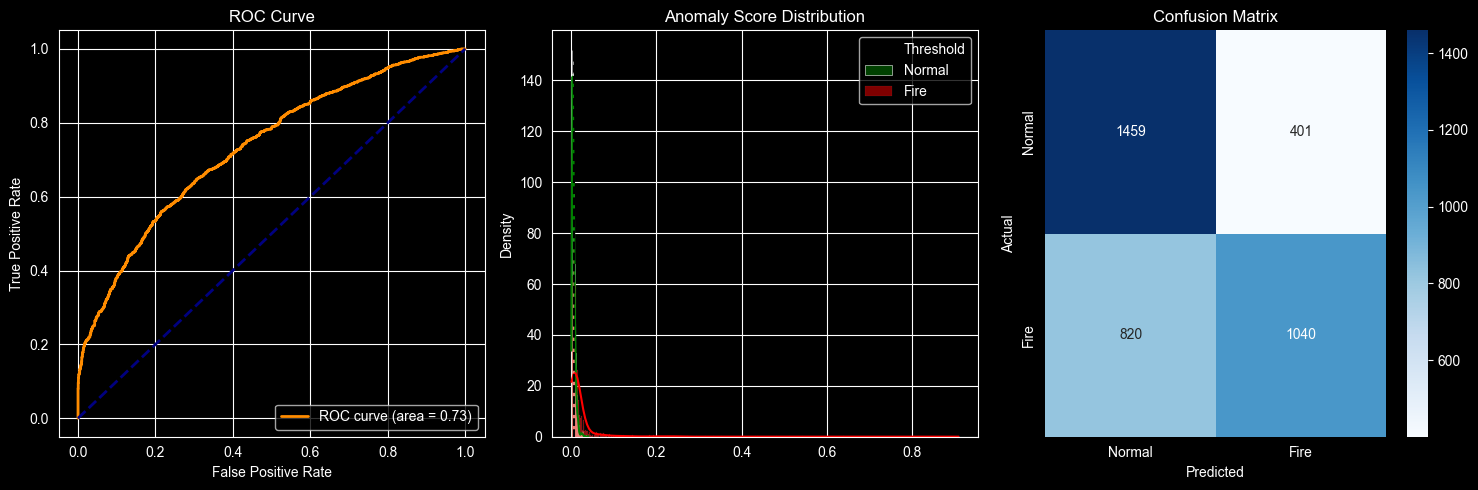

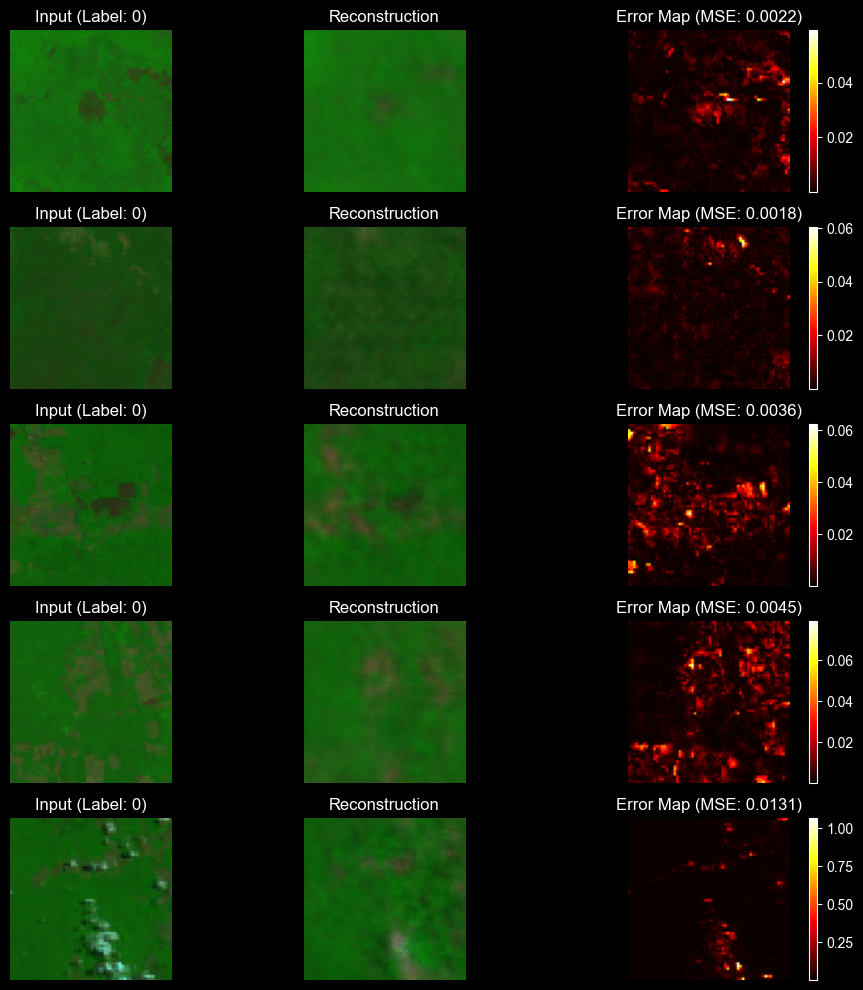

In [59]:
# 6. Plotting
plot_results(fpr, tpr, roc_auc, all_labels, all_scores, optimal_threshold, cm)
visualize_reconstructions(saved_examples)